# Summary

TLDR

Write up executive summary

List of good newsletters/Data science articles:

- NYC data Jobs and Events by Josh Laurito
    - https://tinyletter.com/nycdatajobs
- Normcore Tech by Vicki Boykis
    - https://vicki.substack.com/
- Data Science Roundup by Tristan Handy
    - http://roundup.fishtownanalytics.com/
- The Algorithm from MIT Technology Review
    - https://forms.technologyreview.com/newsletters/
- PyCoder's Weekly     
    - https://pycoders.com/
- Natural Language Processing News by Sebastian Ruder
    - http://newsletter.ruder.io/

# Imports and Functions

In [7]:
import pandas as pd
import altair as alt
import numpy as np
import pandas_profiling
import matplotlib.font_manager
from IPython.display import display
import os
from geopy import distance

RendererRegistry.enable('notebook')

In [ ]:
# Run this cell only if you are running this in a jupyter notebook
alt.renderers.enable('notebook')

In [20]:
def alt_hist(df: pd.DataFrame, col_of_int: str) -> pd.DataFrame:
    """
    Create a dataframe of the counts of each value
    """
    df_tmp = df[[col_of_int]].copy()
    df_tmp["col_count"] = 1
    df_tmp = df_tmp.groupby(col_of_int, as_index=False, sort=False).count()
    return df_tmp

# Download and Concatenate the Data

In [3]:
!mkdir data
!mkdir data/raw
!wget -P data/raw https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip
!wget -P data/raw https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip
!wget -P data/raw https://s3.amazonaws.com/tripdata/201907-citibike-tripdata.csv.zip
!wget -P data/raw https://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip

--2019-10-25 12:03:24--  https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104185546 (99M) [application/zip]
Saving to: ‘data/raw/201909-citibike-tripdata.csv.zip’

201909-citibike-tri 100%[===================>]  99.36M  90.0MB/s    in 1.1s    

2019-10-25 12:03:26 (90.0 MB/s) - ‘data/raw/201909-citibike-tripdata.csv.zip’ saved [104185546/104185546]

--2019-10-25 12:03:26--  https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100021943 (95M) [application/zip]
Saving to: ‘data/raw/201908-citibike-tripdata.csv.zip’

201908-citibike-tri 100%[===================>]

In [5]:
!unzip -q data/raw/201909-citibike-tripdata.csv.zip -d data/raw/
!unzip -q data/raw/201908-citibike-tripdata.csv.zip -d data/raw/
!unzip -q data/raw/201907-citibike-tripdata.csv.zip -d data/raw/
!unzip -q data/raw/201906-citibike-tripdata.csv.zip -d data/raw/

In [8]:
cb_csv = [x for x in os.listdir("data/raw") if x.endswith(".csv")]
df_cb_list = []
for csv in cb_csv:
    df_cb_list.append(pd.read_csv(os.path.join("data/raw",csv)))
df_cb = pd.concat(df_cb_list, ignore_index=True, sort=False)
del cb_df_list
df_cb = df_cb.rename(columns={x:x.replace(" ", "_") for x in cb_df.columns})

In [9]:
df_cb.to_feather("data/citibike_data_201906-201909.feather")

# Load the Data

In [10]:
df_cb = pd.read_feather("data/citibike_data_201906-201909.feather")
df_cb.shape

(9095558, 15)

In [13]:
df_cb.starttime = pd.to_datetime(df_cb.starttime, format="%Y-%m-%d %H:%M:%S.%f")
df_cb.stoptime = pd.to_datetime(df_cb.stoptime, format="%Y-%m-%d %H:%M:%S.%f")

# Profile the Data

In [6]:
# profile = df_cb.profile_report(title="Pandas Profiling Report")
# profile.to_file(output_file="../data/citibike_data_report.html")

# Basic Feature Engineering

# EDA

**EDA General Guidelines**

- You need to look at the data.  Just because pandas says there are no missing values, doesn't mean there aren't thousands of fields that say "none" or "NULL".
- Look for outliers and values that make no sense and remove, correct, or impute them as necessary. But make sure to **explain why you are altering the data**
- Initially, only do the basic EDA/sanity checks.  If you have more time, do more, but do not spend your entire alloted time doing EDA

## Trip Duration, Start Time, End Time

### Sanity Checks

#### Check for missing values

In [80]:
df_cb[["starttime", "stoptime", "tripduration"]].isna().sum()

starttime       0
stoptime        0
tripduration    0
dtype: int64

#### No one arrives before they leave

In [77]:
(df_cb.starttime > df_cb.stoptime).sum()

0

#### The trip duration matches the difference between the `starttime` and the `stoptime`

In [79]:
df_cb["calculatedduration"] = (df_cb.stoptime - df_cb.starttime).dt.total_seconds().astype(int)
df_cb.loc[df_cb.calculatedduration != df_cb.tripduration, ["calculatedduration", "tripduration"]]
df_cb["duration_diff"] = df_cb.calculatedduration -  df_cb.tripduration
df_cb.duration_diff.value_counts()

0    9095558
Name: duration_diff, dtype: int64

### Trip Duration

In [ ]:
df_cb["tripduration_min"] = (df_cb.tripduration/60).astype(int)

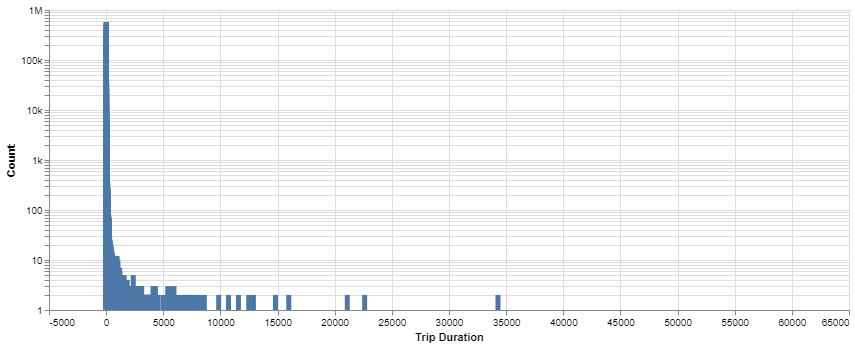

In [26]:
df_tmp = alt_hist(df_cb, col_of_int="tripduration_min")

alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X("tripduration_min:Q", title="Trip Duration", axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s"), scale=alt.Scale(type="log", base=10)),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("tripduration_min", title="Trip Duration")]
).properties(height=300, width=800).interactive()

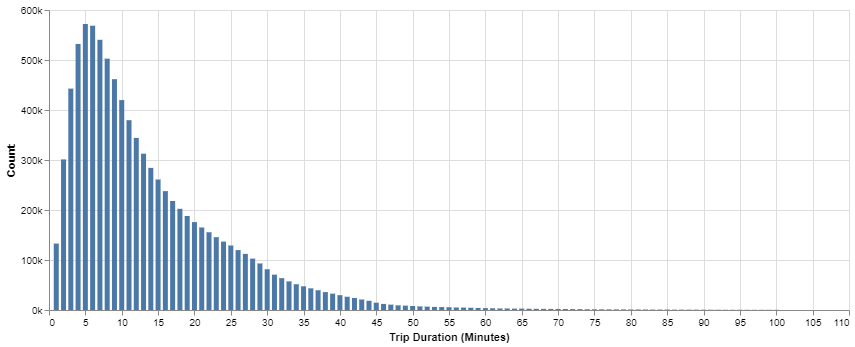

In [38]:
alt.Chart(df_tmp.loc[df_tmp.tripduration_min<=100]).mark_bar().encode(
    x = alt.X("tripduration_min:Q", title="Trip Duration (Minutes)", axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("tripduration_min", title="Trip Duration")]
).properties(height=300, width=800)

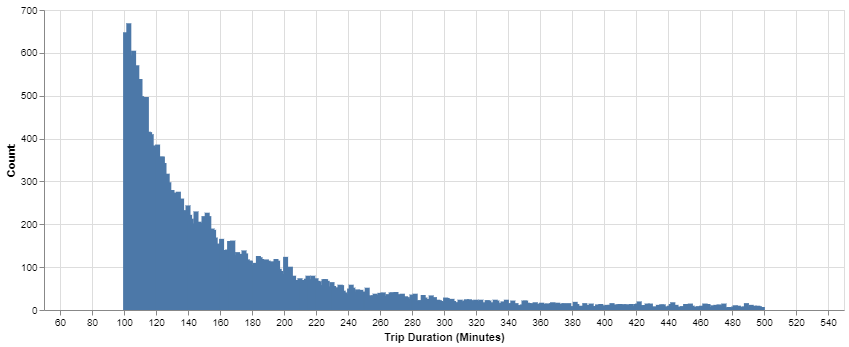

In [39]:
alt.Chart(df_tmp.loc[(df_tmp.tripduration_min>100) & (df_tmp.tripduration_min<500)]).mark_bar().encode(
    x = alt.X("tripduration_min:Q", title="Trip Duration (Minutes)", axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("tripduration_min", title="Trip Duration")]
).properties(height=300, width=800).interactive()

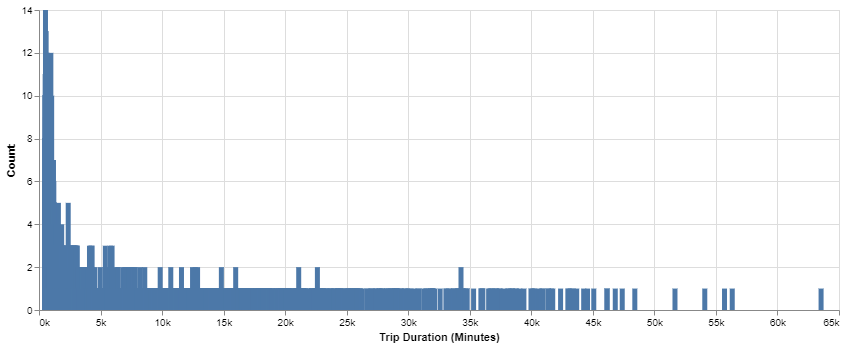

In [41]:
alt.Chart(df_tmp.loc[(df_tmp.tripduration_min>500) ]).mark_bar().encode(
    x = alt.X("tripduration_min:Q", title="Trip Duration (Minutes)", axis=alt.Axis(format="s")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("tripduration_min", title="Trip Duration")]
).properties(height=300, width=800).interactive()

### Start Time

In [62]:
df_cb["start_month"] = df_cb.starttime.dt.month
df_cb["start_day"] = df_cb.starttime.dt.day
df_cb["start_date"] = pd.to_datetime(df_cb.starttime.dt.date, format="%Y-%m-%d")
df_cb["start_dow"] = df_cb.starttime.dt.day_name()
df_cb["start_hour"] = df_cb.starttime.dt.hour

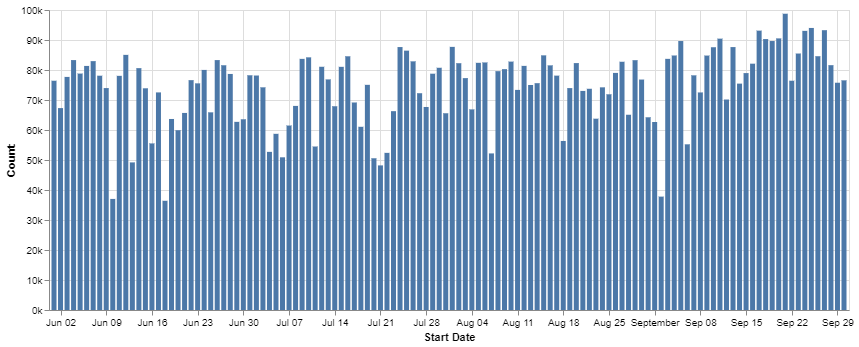

In [74]:
df_tmp = alt_hist(df_cb, col_of_int="start_date")
df_tmp = df_tmp.merge(df_cb[["start_date", "start_dow"]].drop_duplicates(), on="start_date", how="left")

alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X("start_date:T", title="Start Date"),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("start_date", title="Date"),
            alt.Tooltip("start_dow", title="Day of Week")]
).properties(height=300, width=800).interactive()

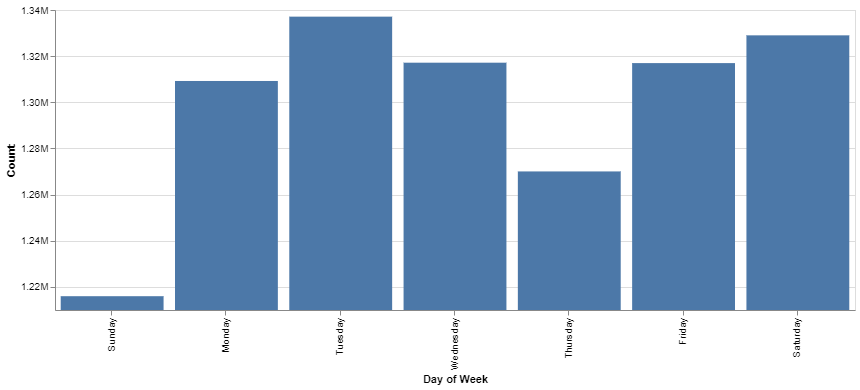

In [66]:
col_of_int = "start_dow"
col_title = "Day of Week"
df_tmp = alt_hist(df_cb, col_of_int=col_of_int)

alt.Chart(df_tmp).mark_bar().encode(
    x=alt.X(
        col_of_int,
        title=col_title,
        sort=[
            "Sunday",
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
        ],
    ),
    y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s"), scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],
).properties(height=300, width=800)

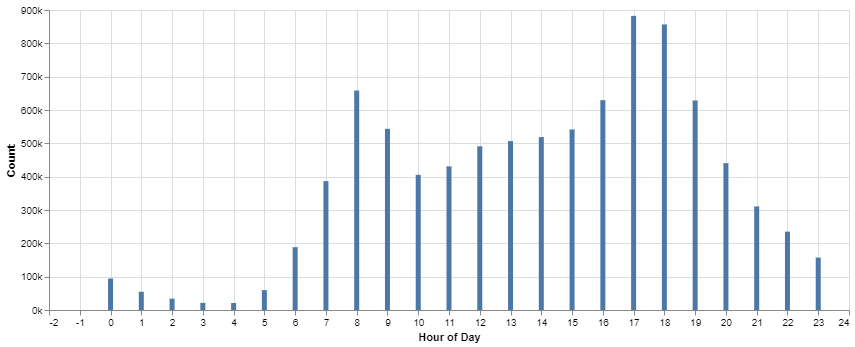

In [76]:
col_of_int = "start_hour"
col_title = "Hour of Day"
df_tmp = alt_hist(df_cb, col_of_int=col_of_int)

alt.Chart(df_tmp).mark_bar().encode(
    x=alt.X(
        col_of_int,
        title=col_title,
    ),
    y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s"), scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],
).properties(height=300, width=800)

## Start Stations and End Stations

### Sanity Checks

#### Missing Values

In [86]:
df_cb.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'start_month', 'start_day', 'tripduration_min',
       'start_date', 'start_hour', 'start_dow', 'calculatedduration',
       'duration_diff'],
      dtype='object')

In [87]:
df_cb[
    [
        "start_station_id",
        "start_station_name",
        "start_station_latitude",
        "start_station_longitude",
        "end_station_id",
        "end_station_name",
        "end_station_latitude",
        "end_station_longitude",
    ]
].isna().sum()

start_station_id           143
start_station_name         143
start_station_latitude       0
start_station_longitude      0
end_station_id             143
end_station_name           143
end_station_latitude         0
end_station_longitude        0
dtype: int64

#### Check for any empty strings

In [104]:
df_cb.loc[(df_cb.start_station_name.notna()) & (df_cb.start_station_name.str.match("^\s*$"))]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bikeid, usertype, birth_year, gender, start_month, start_day, tripduration_min, start_date, start_hour, start_dow, calculatedduration, duration_diff]
Index: []

[0 rows x 23 columns]

In [105]:
df_cb.loc[(df_cb.end_station_name.notna()) & (df_cb.end_station_name.str.match("^\s*$"))]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bikeid, usertype, birth_year, gender, start_month, start_day, tripduration_min, start_date, start_hour, start_dow, calculatedduration, duration_diff]
Index: []

[0 rows x 23 columns]

#### Check for any null/none/test or equivalent strings

In [108]:
df_cb.loc[df_cb.start_station_name.str.len()<10].start_station_name.unique()

array(['Cherry St'], dtype=object)

In [109]:
df_cb.loc[df_cb.end_station_name.str.len()<10].end_station_name.unique()

array(['Cherry St', 'Grand St', 'Hilltop', 'City Hall', 'Sip Ave',
       'York St', 'Union St'], dtype=object)

In [110]:
set(df_cb.start_station_name.tolist()  + df_cb.end_station_name.tolist())

{'1 Ave & E 110 St',
 '1 Ave & E 16 St',
 '1 Ave & E 18 St',
 '1 Ave & E 30 St',
 '1 Ave & E 44 St',
 '1 Ave & E 62 St',
 '1 Ave & E 68 St',
 '1 Ave & E 78 St',
 '1 Ave & E 94 St',
 '1 Pl & Clinton St',
 '10 Ave & W 28 St',
 '10 Hudson Yards',
 '10 St & 2 Ave',
 '10 St & 5 Ave',
 '10 St & 7 Ave',
 '11 Ave & W 27 St',
 '11 Ave & W 41 St',
 '11 Ave & W 59 St',
 '11 St & 35 Ave',
 '11 St & 43 Ave',
 '12 Ave & W 40 St',
 '12 St & 4 Ave',
 '14 St & 5 Ave',
 '14 St & 7 Ave',
 '19 St & 24 Ave',
 '2 Ave & 36 St - Citi Bike HQ at Industry City',
 '2 Ave & E 104 St',
 '2 Ave & E 122 St',
 '2 Ave & E 31 St',
 '2 Ave & E 72 St',
 '2 Ave & E 96 St',
 '2 Ave & E 99 St',
 '21 St & 31 Dr',
 '21 St & 36 Ave',
 '21 St & 38 Ave',
 '21 St & 43 Ave',
 '21 St & Hoyt Ave S',
 '21 St & Queens Plaza North',
 '23 Ave & 27 St',
 '24 Ave & 26 St',
 '24 Ave & 29 St',
 '24 St & 41 Ave',
 '27 Ave & 3 St',
 '27 Ave & 4 St',
 '27 Ave & 9 St',
 '27 St & Hunter St',
 '28 Ave & 35 St',
 '28 Ave & 44 St',
 '28 St & 36 Ave

NYCBS Depot locations are test locations and should be removed from the dataset

In [125]:
start_station_test = df_cb.loc[(df_cb.start_station_name.notna()) & (df_cb.start_station_name.str.contains("NYCBS"))]
print(start_station_test.shape)
df_cb = df_cb.loc[~df_cb.index.isin(start_station_test.index)]

(26, 23)


In [126]:
end_station_test = df_cb.loc[(df_cb.end_station_name.notna()) & (df_cb.end_station_name.str.contains("NYCBS"))]
print(end_station_test.shape)
df_cb = df_cb.loc[~df_cb.index.isin(end_station_test.index)]

(368, 23)


#### Check that the same station_id always matches the same station_name (Extra)

In [90]:
start_st = (
    df_cb[
        [
            "start_station_id",
            "start_station_name",
            "start_station_latitude",
            "start_station_longitude",
        ]
    ]
    .drop_duplicates()
    .dropna()
)
display(
    start_st.loc[start_st.start_station_name.duplicated(keep=False)].sort_values(
        "start_station_name"
    )
)
end_st = (
    df_cb[
        [
            "end_station_id",
            "end_station_name",
            "end_station_latitude",
            "end_station_longitude",
        ]
    ]
    .drop_duplicates()
    .dropna()
)
display(
    end_st.loc[end_st.end_station_name.duplicated(keep=False)].sort_values(
        "end_station_name"
    )
)

start_station_id        start_station_name  start_station_latitude  \
1480471             250.0  Lafayette St & Jersey St               40.724561   
2344249            3427.0  Lafayette St & Jersey St               40.724305   
72                  382.0   University Pl & E 14 St               40.734927   
7907956            3812.0   University Pl & E 14 St               40.734814   
1917506            3809.0           W 55 St & 6 Ave               40.763201   
6650911            3809.0           W 55 St & 6 Ave               40.763189   

         start_station_longitude  
1480471               -73.995653  
2344249               -73.996010  
72                    -73.992005  
7907956               -73.992085  
1917506               -73.978458  
6650911               -73.978434

end_station_id          end_station_name  end_station_latitude  \
1480222           250.0  Lafayette St & Jersey St             40.724561   
2344947          3427.0  Lafayette St & Jersey St             40.724305   
207               382.0   University Pl & E 14 St             40.734927   
7906000          3812.0   University Pl & E 14 St             40.734814   
1915288          3809.0           W 55 St & 6 Ave             40.763201   
6651093          3809.0           W 55 St & 6 Ave             40.763189   

         end_station_longitude  
1480222             -73.995653  
2344947             -73.996010  
207                 -73.992005  
7906000             -73.992085  
1915288             -73.978458  
6651093             -73.978434

### Start Stations

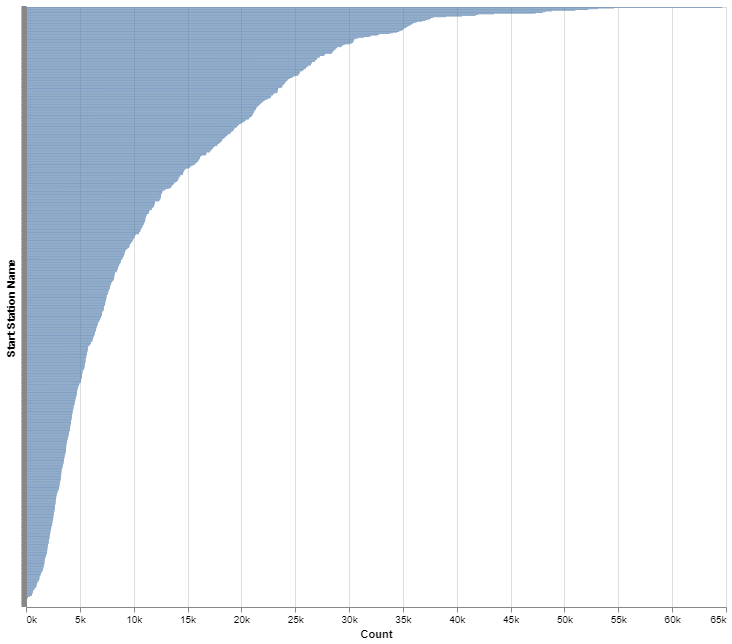

In [141]:
col_of_int = "start_station_name"
col_title = "Start Station Name"
df_tmp = alt_hist(df_cb, col_of_int)

alt.Chart(df_tmp).mark_bar().encode(
    x=alt.X("col_count", title="Count", axis=alt.Axis(format="s")),
    y=alt.Y(
        col_of_int,
        title = col_title,
        sort=alt.EncodingSortField(
            field="col_count", 
            order="descending",  
        ),
        axis= alt.Axis(labels=False)
    ),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],    
).properties(height=600, width=700)

### End Stations

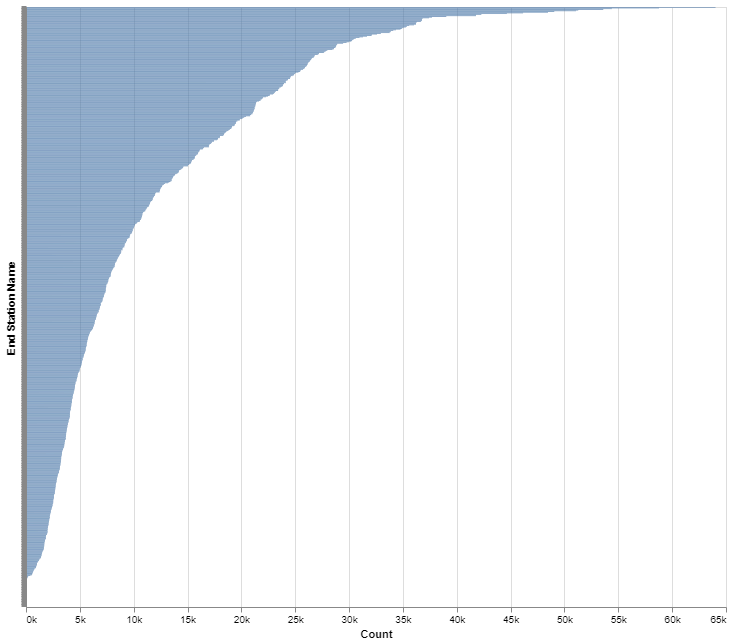

In [142]:
col_of_int = "end_station_name"
col_title = "End Station Name"
df_tmp = alt_hist(df_cb, col_of_int)

alt.Chart(df_tmp).mark_bar().encode(
    x=alt.X("col_count", title="Count", axis=alt.Axis(format="s")),
    y=alt.Y(
        col_of_int,
        title = col_title,
        sort=alt.EncodingSortField(
            field="col_count", 
            order="descending",  
        ),
        axis= alt.Axis(labels=False)
    ),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],    
).properties(height=600, width=700)

## User Type, Birth Year, and Gender

### Sanity Checks

#### Check for null values

In [145]:
df_cb[["usertype", "birth_year", "gender"]].isna().sum()

usertype      0
birth_year    0
gender        0
dtype: int64

### User Type

In [182]:
df_cb.usertype.value_counts(dropna=False)

Subscriber    7466131
Customer      1629033
Name: usertype, dtype: int64

### Gender

In [183]:
df_cb.gender.value_counts(dropna=False)

1    5982243
2    2286752
0     826169
Name: gender, dtype: int64

I am assuming that 1 is male, 2 is female, and 0 is unknown/other

### Birth Year

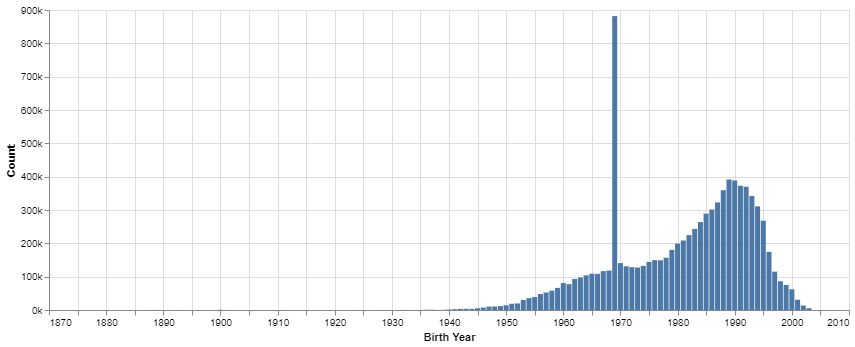

In [146]:
col_of_int = "birth_year"
col_title = "Birth Year"
df_tmp = alt_hist(df_cb, col_of_int)

alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title)]
).properties(height=300, width=800).interactive()

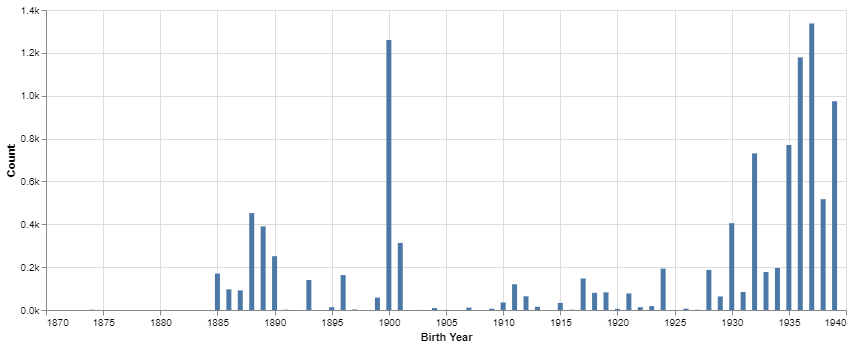

In [148]:
alt.Chart(df_tmp.loc[df_tmp.birth_year<1940]).mark_bar().encode(
    x = alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title)]
).properties(height=300, width=800).interactive()

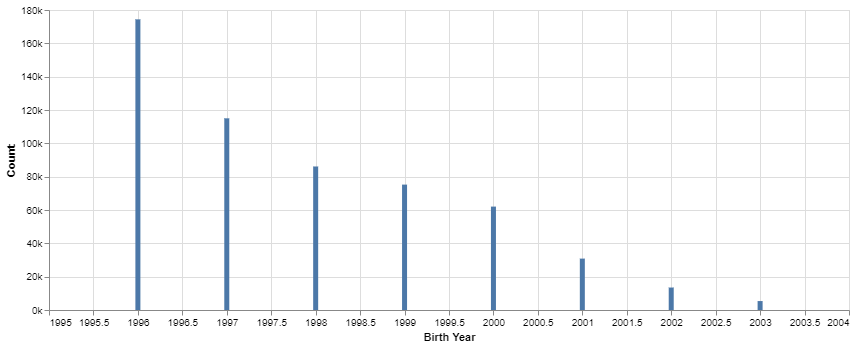

In [149]:
alt.Chart(df_tmp.loc[df_tmp.birth_year>1995]).mark_bar().encode(
    x = alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title)]
).properties(height=300, width=800).interactive()

I would assume that 1969 is the default `birth year` value, hence its spike.  To prevent them from skewing any analysis, I will replace them with null values.  There are definitely some false values in that dataset, as I doubt there are any bikers over 120 years old, but there is no obvious cutoff.  However, since they are on the edge of the data they should influence any trends. 

In [150]:
df_cb.loc[df_cb.birth_year==1969, "birth_year"] = np.NAN

# Data Relationships

## Trip Duration vs Trip Distance

In [156]:
df_latlong = (
    df_cb[
        [
            "start_station_latitude",
            "start_station_longitude",
            "end_station_longitude",
            "end_station_latitude",
        ]
    ]
    .drop_duplicates()
    .copy()
)
df_latlong.shape

(311837, 4)

In [157]:
df_latlong["start_lat_long"] = list(
    zip(df_latlong.start_station_latitude, df_latlong.start_station_longitude)
)
df_latlong["end_lat_long"] = list(
    zip(df_latlong.end_station_latitude, df_latlong.end_station_longitude)
)

In [163]:
df_latlong["trip_distance"] = df_latlong.apply(
    lambda x: distance.distance(x.start_lat_long, x.end_lat_long).miles, axis=1
)

In [168]:
df_cb = df_cb.merge(
    df_latlong,
    on=[
        "start_station_latitude",
        "start_station_longitude",
        "end_station_longitude",
        "end_station_latitude",
    ],
    how="left"
)

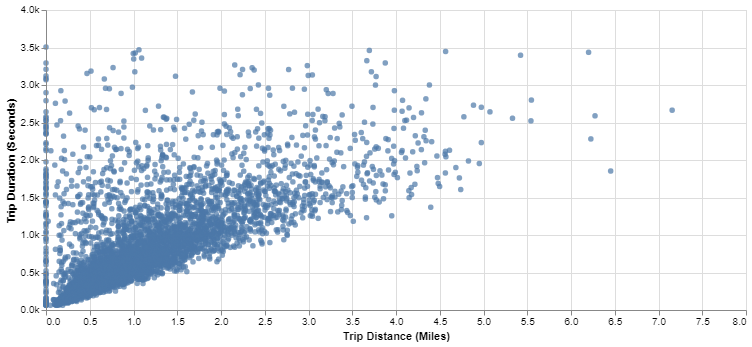

In [179]:
df_tmp = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["trip_distance", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

alt.Chart(df_tmp).mark_circle().encode(
    x=alt.X("trip_distance", title="Trip Distance (Miles)"),
    y=alt.Y("tripduration", title="Trip Duration (Seconds)", axis=alt.Axis(format="s")),
    tooltip=[
        alt.Tooltip("tripduration", title="Duration (Seconds)", format="s"),
        alt.Tooltip("trip_distance", title="Distance (Miles)"),
    ],
).properties(height=300, width=700)

In [190]:
df_cb.trip_distance.corr(df_cb.tripduration)

0.050609609213969085

## Trip Duration vs Birth Year

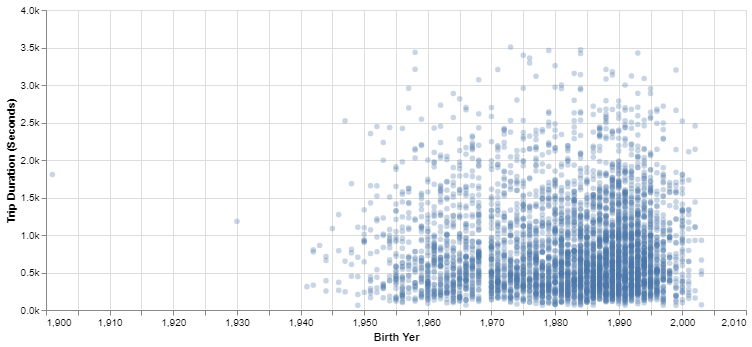

In [188]:
df_tmp = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["birth_year", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

alt.Chart(df_tmp).mark_circle(opacity=0.3).encode(
    x=alt.X("birth_year", title="Birth Yer",scale=alt.Scale(zero=False)),
    y=alt.Y("tripduration", title="Trip Duration (Seconds)", axis=alt.Axis(format="s")),
    tooltip=[
        alt.Tooltip("tripduration", title="Duration (Seconds)", format="s"),
        alt.Tooltip("birth_year", title="Birth Year"),
    ],
).properties(height=300, width=700)

In [189]:
df_cb.birth_year.corr(df_cb.tripduration)

0.0062078380700601845

In [126]:
df_cb.head().apply(lambda x: distance((x.start_station_latitude, x.start_station_longitude), (x.end_station_latitude, x.end_station_longitude)), axis=1)

0    0.673866
1    1.487531
2    0.570477
3    0.722958
4    0.887327
dtype: float64

In [124]:
df_cb.head()

tripduration               starttime                stoptime  \
0           311 2019-05-01 00:07:36.467 2019-05-01 00:12:47.635   
1           538 2019-05-01 00:08:29.284 2019-05-01 00:17:27.941   
2           178 2019-05-01 00:39:36.475 2019-05-01 00:42:34.964   
3           317 2019-05-01 01:24:28.022 2019-05-01 01:29:45.573   
4           354 2019-05-01 01:54:39.666 2019-05-01 02:00:34.175   

   start_station_id start_station_name  start_station_latitude  \
0              3185          City Hall               40.717733   
1              3681           Grand St               40.715178   
2              3638      Washington St               40.724294   
3              3206            Hilltop               40.731169   
4              3639         Harborside               40.719252   

   start_station_longitude  end_station_id end_station_name  \
0               -74.043845            3279      Dixon Mills   
1               -74.037683            3203    Hamilton Park   
2               -74.035483            3639       Harborside   
3               -74.057574            3212  Christ Hospital   
4               -74.034234            3202     Newport PATH   

   end_station_latitude  ...  bikeid    usertype birth_year  gender  \
0             40.721630  ...   29224  Subscriber     1988.0       1   
1             40.727596  ...   26170  Subscriber     1974.0       1   
2             40.719252  ...   29517  Subscriber     1988.0       1   
3             40.734786  ...   29606  Subscriber     1986.0       2   
4             40.727224  ...   26224    Customer     1986.0       2   

   start_year  start_month  start_day  start_year_month calculatedduration  \
0        2019            5          1        2019-05-01                311   
1        2019            5          1        2019-05-01                538   
2        2019            5          1        2019-05-01                178   
3        2019            5          1        2019-05-01                317   
4        2019            5          1        2019-05-01                354   

   duration_diff  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 21 columns]

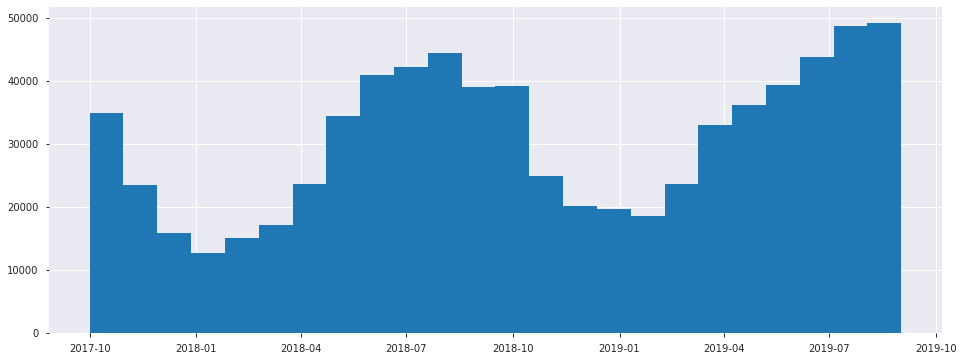

In [33]:
df_cb.start_year_month.hist(figsize=(16,6), bins=24)

In [15]:
df_cb.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [14]:
aa = alt.Chart()

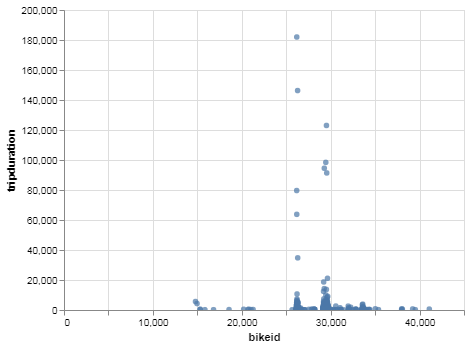

In [19]:
df_tmp = df_cb.sample(5 * 10 ** 3)

alt.Chart(df_tmp).mark_circle().encode(x=alt.X("bikeid"), y=alt.Y("tripduration")).interactive()